In [12]:
import sys
sys.path.append('..')
import feature_spaces
import encoding_utils
import dvu
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import seaborn as sns
import os
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeCV, LogisticRegressionCV

from typing import List
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import datasets
import encoding_utils, feature_spaces, imodelsx
%load_ext autoreload
%autoreload 2

from feature_spaces import *
from feature_spaces import em_data_dir, data_dir, results_dir
# from fit_linear_models import get_dsets
# from ridge_utils.SemanticModel import SemanticModel
dvu.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Select best voxel

In [3]:
k = 'bert-10__ndel=4'
results_dir = join(results_dir, 'encoding', k, 'UTS03')
corrs = np.load(join(results_dir, 'corrs.npz'))['arr_0']
idxs = np.argsort(corrs)[::-1]
idx_best = idxs[0]
corrs[idx_best]

### Load weight

In [8]:
weights = np.load(join(results_dir, 'weights.npz'))['arr_0']
ndelays = 4
weights = weights.reshape(ndelays, -1, weights.shape[-1])
weights = weights.mean(axis=0).squeeze()  # mean over delays dimension...
w = weights[:, idx_best].flatten()

### Load story texts

In [ ]:
# Look at narrative stories
train_stories, test_stories, allstories = encoding_utils.get_allstories([1, 2, 3, 4, 5])
wordseqs = feature_spaces.get_story_wordseqs(allstories)
texts = [' '.join(wordseqs[k].data) for k in wordseqs.keys()]

### Calculate ngram coefs for weight

In [35]:
m = imodelsx.EmbGAMClassifier(
    checkpoint='bert-base-uncased',
    ngrams=3,
    all_ngrams=True,
)
m.linear = RidgeCV()
m.linear.coef_ = w

In [36]:
m.cache_linear_coefs(texts)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 81791/81791 [10:20<00:00, 131.78it/s]


coefs_dict_ len 81791


### Plot top ngram coefs

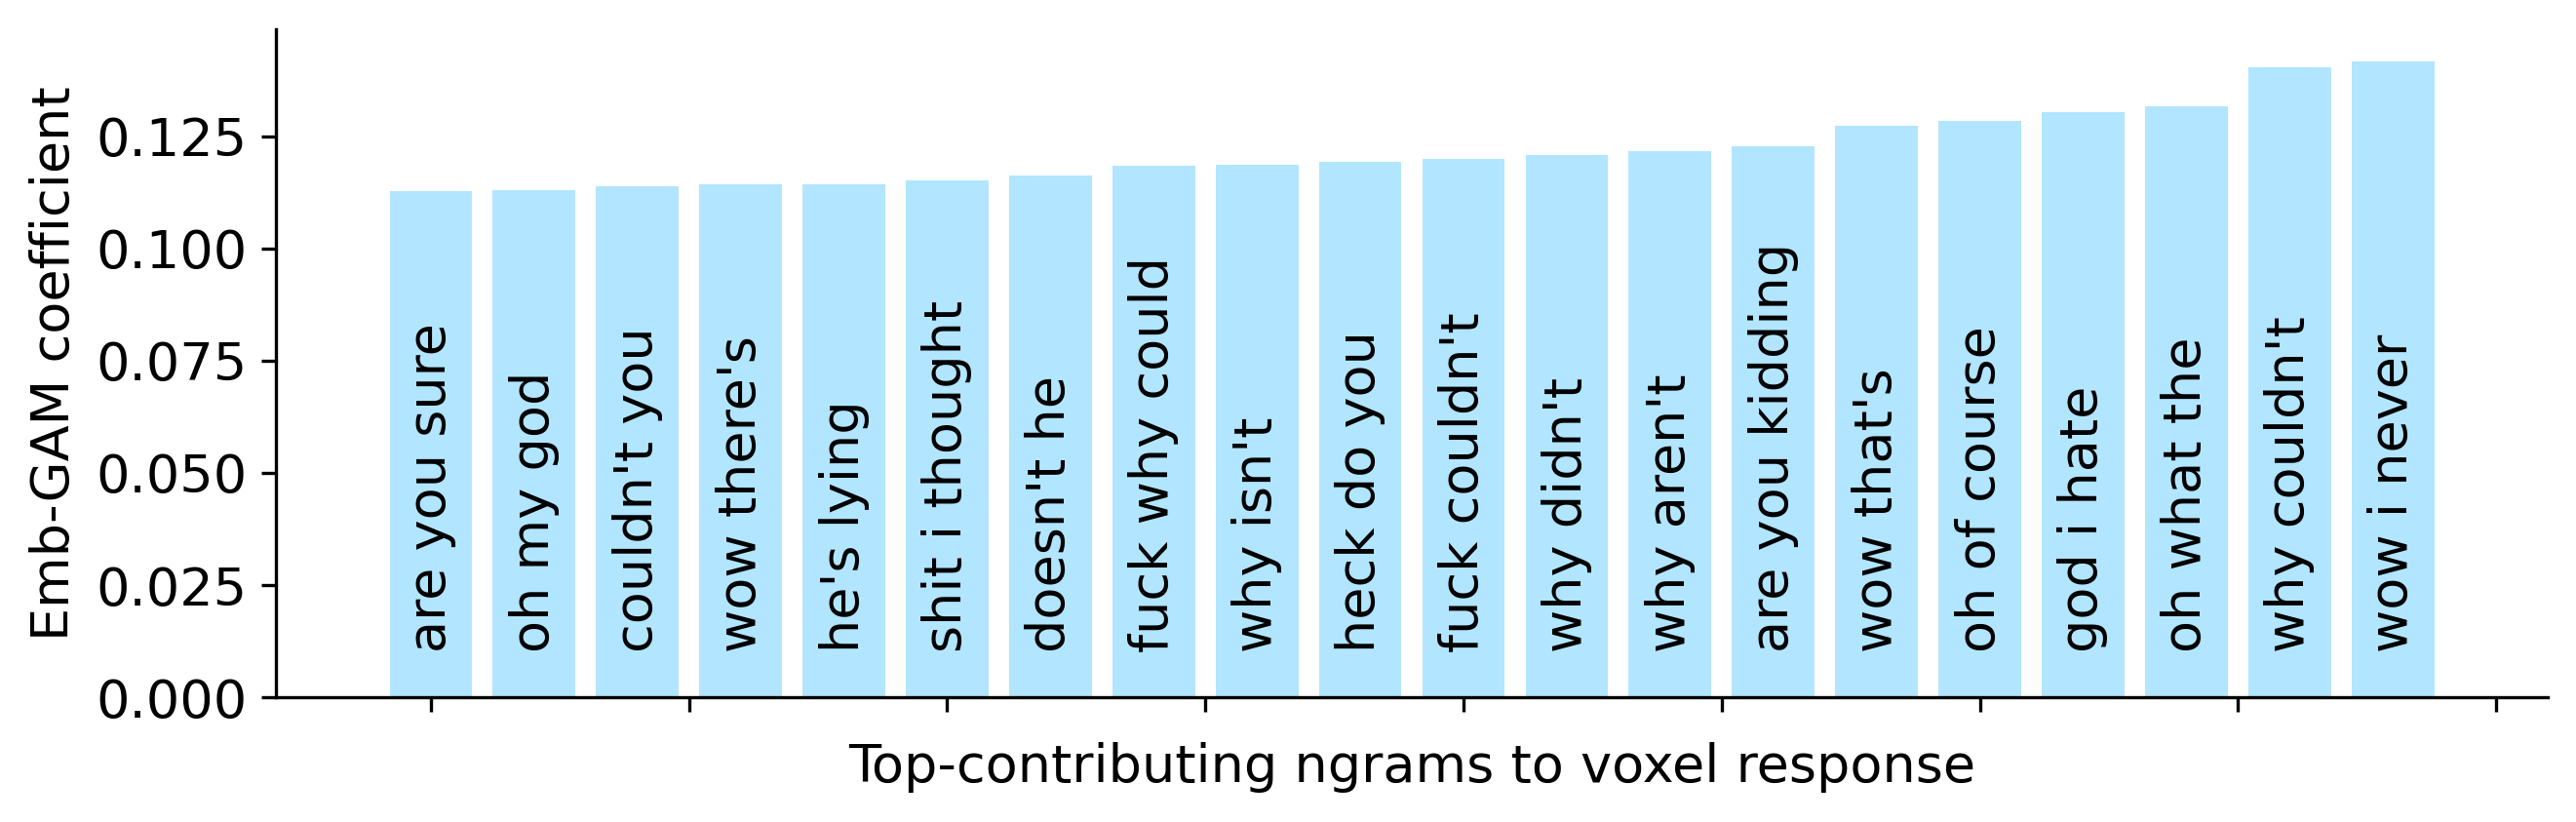

In [48]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(dpi=300, figsize=(9, 3))
logits = np.array(list(m.coefs_dict_.values()))
seqs = np.array(list(m.coefs_dict_.keys()))

# pick top
num_top = 20
args = np.argsort(logits)
args = args[-num_top:]

# make plot
x = np.arange(args.size)
y = logits[args]
labels = np.array(seqs)[args].astype(str).tolist()
p1 = ax.bar(x=x, height=y, color=[dvu.cb] * num_top, alpha=0.5)
ax.set_xticklabels([])
# remove the extra tick on the negative bar
# ax.set_xticks([idx for (idx, x) in enumerate(performance) if x > 0])
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


label_offset = 0.01
for label, (x_position, y_position) in zip(labels, enumerate(y)):
    # if y_position > 0:
        # label_y = -label_offset
        # ax.text(x_position, label_y, label, ha="center", va="top", rotation=90)
    # else:
    label_y = +label_offset
    ax.text(x_position, label_y, label, ha="center", va="bottom", rotation=90)
# Placing the x-axis label, note the transformation into `Axes` co-ordinates
# previously data co-ordinates for the x ticklabels
# ax.text(0.5, 0.01, "Top-contributing ngrams to voxel response", ha="center", va="top", transform=ax.transAxes)
plt.xlabel("Top-contributing ngrams to voxel response") #, ha="center", va="top", transform=ax.transAxes)
plt.ylabel('Emb-GAM coefficient')
plt.xlim([-1.5 , x.size + 0.5])
plt.tight_layout()
plt.savefig('../figs/voxel_ngram_contribution.pdf')
plt.show()